In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[]


In [2]:
import cv2
import numpy as np
import ipywidgets as widgets
from IPython.display import display, Javascript
from base64 import b64decode
import numpy as np
from IPython.display import Image
from PIL import Image as PIL_Image
import os
from IPython.display import clear_output as cls
from tqdm import tqdm
from glob import glob
import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
def cv2_imshow(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.imwrite("photo2.jpg", img)
    cv2.destroyAllWindows()
    
def capture_image():
    cap = cv2.VideoCapture(0)  # 0 is the default camera
    success, frame = cap.read()
    if success:
        cv2.imshow('Captured Image', frame)
        cv2.waitKey(0)  # Wait for a key press to close the window
        cv2.imwrite('output.jpg', frame)  # Save the frame as JPEG file
    cap.release()
    cv2.destroyAllWindows()


In [4]:
import ipywidgets as widgets
from IPython.display import display

# fileupload widget
uploader = widgets.FileUpload(
    accept='.pb, .pbtxt',  #accepted file types
    multiple=True  # multiple files
)
display(uploader)

# handle file uploads
def handle_upload(change):
    for filename, file_info in uploader.value.items():
        print(f"Filename: {filename}")
        # access file content
        content = file_info['content']
        with open(filename, 'wb') as f:
            f.write(content)
        print(f"{filename} has been saved successfully.")

# Attach the event handler to the uploader
uploader.observe(handle_upload, names='value')


FileUpload(value=(), accept='.pb, .pbtxt', description='Upload', multiple=True)

In [5]:
pb_file = 'C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\deep learnning\\opencv_face_detector_uint8.pb'
pbtxt_file = 'C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\deep learnning\\opencv_face_detector.pbtxt'

In [6]:
# Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_file, pbtxt_file)

### crop images

In [7]:
import os
path = "C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\archive"
path_original = os.path.join(path, "105_classes_pins_dataset")
classes = os.listdir(path_original)
all_pics = dict({})
i = 0
feature=[]
label = []
for class_no, c in enumerate(classes):
    c_path = os.path.join(path_original,c)
    pics_in_c = os.listdir(c_path)
    for p in pics_in_c:
        pic_path = os.path.join(c_path, p)
        #all_pics[c].append(pic_path)
        img_pil = PIL_Image.open(pic_path)
        frame = np.array(img_pil)
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
        net.setInput(blob)
        detections = net.forward()
        box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
        (startX, startY, endX, endY) = box.astype("int")
        #new_path = os.path.join(path, "cropped", c,p)
        #print(new_path)
        frame = frame[startY:endY , startX:endX]
        image = PIL_Image.fromarray(frame)
        image = image.resize((150,150))
        frame = np.array(image)
        feature.append(frame)
        label.append(class_no)

        class_dir = os.path.join(path, "cropped", c)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        new_path = os.path.join(class_dir,p)
        image.save(new_path)
        





### train test split and one hot encoding

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

feature = np.array(feature)/255.0
label = np.array(label)
label = label.reshape((-1,1))
label = to_categorical(label,105)

x_train, x_val, y_train, y_val = train_test_split(feature, label, test_size=0.2, random_state=42, shuffle=True)

### model

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2

local_weights_file = 'C:\\Users\\merva\\OneDrive\\Desktop\\uni\\AI\\deep learnning\\inception\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
# #pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='leaky_relu', activity_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(105, activation='softmax')(x) 
          

model = Model(pre_trained_model.input, x) 


last layer output shape:  (None, 7, 7, 768)


In [10]:
x_train.shape

(14027, 150, 150, 3)

In [11]:
y_train.shape

(14027, 105)

In [12]:
x_val.shape

(3507, 150, 150, 3)

In [13]:
y_val.shape

(3507, 105)

### load model 

In [13]:
model = tf.keras.models.load_model('face_recognition.h5')

### train model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
callback = [EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True, verbose=1)]
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
history=model.fit(x_train, y_train,epochs=20,callbacks=callback,  batch_size=32, validation_data=(x_val, y_val))


Epoch 1/20
439/439 [==============================] - 216s 481ms/step - loss: 4.1148 - acc: 0.1363 - val_loss: 3.0766 - val_acc: 0.2826
Epoch 2/20
439/439 [==============================] - 209s 475ms/step - loss: 2.3538 - acc: 0.4593 - val_loss: 2.2585 - val_acc: 0.4813
Epoch 3/20
439/439 [==============================] - 202s 460ms/step - loss: 1.4703 - acc: 0.6641 - val_loss: 1.9165 - val_acc: 0.5660
Epoch 4/20
439/439 [==============================] - 203s 463ms/step - loss: 0.9639 - acc: 0.7972 - val_loss: 1.9798 - val_acc: 0.5586
Epoch 5/20
439/439 [==============================] - 202s 461ms/step - loss: 0.6600 - acc: 0.8801 - val_loss: 1.7180 - val_acc: 0.6307
Epoch 6/20
439/439 [==============================] - 201s 457ms/step - loss: 0.4952 - acc: 0.9262 - val_loss: 1.6266 - val_acc: 0.6399
Epoch 7/20
439/439 [==============================] - 202s 460ms/step - loss: 0.3837 - acc: 0.9557 - val_loss: 1.5354 - val_acc: 0.6678
Epoch 8/20
439/439 [============================

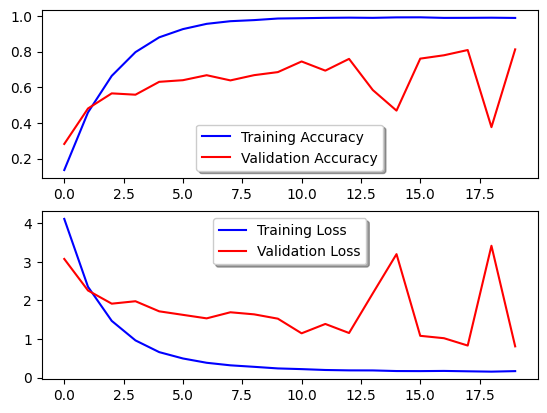

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[0].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training Loss")
ax[1].plot(history.history['val_loss'], color='r', label="Validation Loss")
legend = ax[1].legend(loc='best', shadow=True)


In [17]:
model.save('face_rec.h5')

## optional no class for cosine similarity

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

non_classified_dataset_path = 'unclassified'
unclassified_files = os.listdir(non_classified_dataset_path)
print(f"Number of files in the dataset: {len(unclassified_files)}")

# Prepare to store the preprocessed images as a dataset
preprocessed_dataset = []

# Process each image file
for image_filename in unclassified_files:
    image_full_path = os.path.join(non_classified_dataset_path, image_filename)
    image = cv2.imread(image_full_path)
    image = preprocess_input(image)
    
    # Resize the image to the required size for the model
    image = cv2.resize(image, dsize=(150, 150))
    
    # Normalize pixel values
    image = image.astype(np.float32) / 255.0
    
    # feature representations
    features = model.predict(np.expand_dims(image, axis=0)).flatten()
    preprocessed_dataset.append(features)



In [30]:
# Function to perform face detection on a static photo
def detect_faces(net, frame):
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            # Draw the detection and the confidence:
            text = "{:.3f}%".format(confidence * 100)

            face = frame[startY:endY , startX:endX]
            face = np.array(PIL_Image.fromarray(face.astype('uint8'), 'RGB').resize((150,150)))
            celeb = classes[np.argmax(model.predict(np.expand_dims(face,axis=0)))]
            
## Optional if we want to add the no class and cosine similarity -- uncomment
            # pred = model.predict(np.expand_dims(face,axis=0))
            # sims=[]
            # for f in preprocessed_dataset:
            #     similarity = cosine_similarity(pred, [f])
            #     sims.append(similarity)
            # max_sim = max(sims)
            # if max_similarity > 0.05:
            #     celeb = 'no_class'
            

            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 3)
            cv2.putText(frame, celeb, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Display the result
    cv2_imshow(frame)
    


### live video test

In [28]:
#LIVE CAMERA TEST
cv2.ocl.setUseOpenCL(False)

classification = {index: element for index, element in enumerate(classes)}

# VideoCapture(0 => webcam) otherwise provide the path of the saved video
cap = cv2.VideoCapture(0)

# front face detector (pretrained model) 
Classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    # ret is a bool , True if the frame reading was successful
    # frame is the picture
    ret, frame = cap.read()

    if not ret:
        # closes video
        cap.release()
        cv2.destroyAllWindows()
        break

    
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    frame = np.array(frame)
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.7:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
            pic = frame[startY:endY , startX:endX]
            pic = np.array(PIL_Image.fromarray(pic.astype('uint8'), 'RGB').resize((150,150)))
            res = classes[np.argmax(model.predict(np.expand_dims(pic,axis=0)))]
            
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 3)
            cv2.putText(frame, res, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # show the frame after editting
    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    # to quit video press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break


1/1 [==============================] - 0s 38ms/step


### test on static photo

1/1 [==============================] - 0s 25ms/step


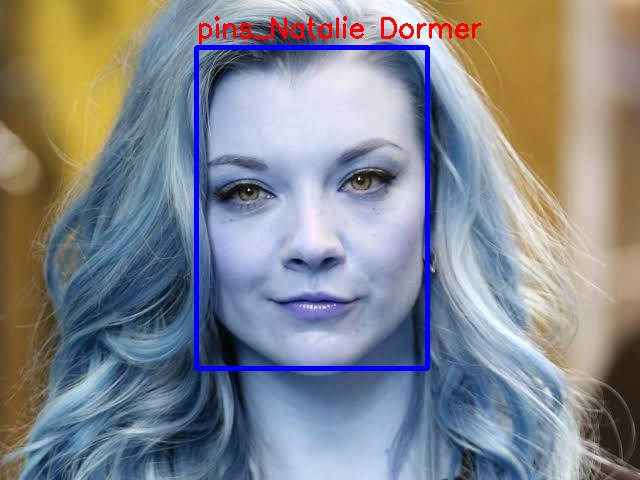

: 

In [31]:
img_pil = PIL_Image.open("natalie.jpg")


# Convert PIL Image to NumPy array
img_np = np.array(img_pil)

detect_faces(net,img_np)

display(Image("photo2.jpg"))

### take static photo

In [ ]:
def take_photo(filename='photo.jpg'):
    # Start the camera
    cap = cv2.VideoCapture(0)
    
    # Check if the camera opened successfully
    if not cap.isOpened():
        print("Cannot open camera")
        return None
        

    else:
       
    
        print("Press 's' to save the photo and quit, or 'q' to quit without saving.")
    
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
        
            # if frame is read correctly ret is True
            if not ret:
                print("Can't receive frame (stream end?). Exiting ...")
                break
        
            # Display the resulting frame
            cv2.imshow('Camera', frame)
        
            key = cv2.waitKey(1)
            if key == ord('s'):
            # Save the frame as a JPEG file
                cv2.imwrite(filename, frame)
                print(f"Photo saved as {filename}")
                break
            elif key == ord('q'):
                print("Exiting without saving.")
                break
    
        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()
        return filename




Press 's' to save the photo and quit, or 'q' to quit without saving.
Photo saved as photo.jpg
Saved to photo.jpg


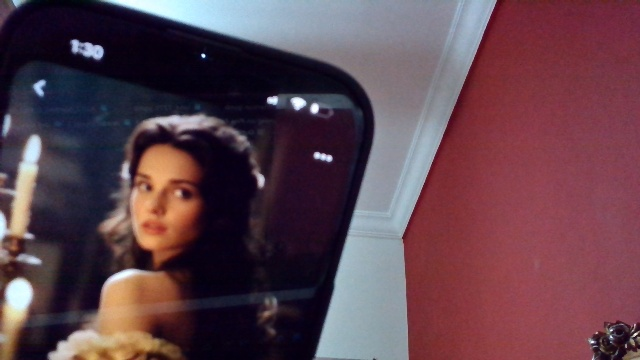

In [18]:

from io import BytesIO

try:
    # Capture the photo
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Load the image using PIL
    img_pil = PIL_Image.open(filename)

    # Convert PIL Image to NumPy array
    img_np = np.array(img_pil)

    # Show the image which was just taken.
    display(Image(filename))

except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not grant the page permission to access it.
    print(str(err))


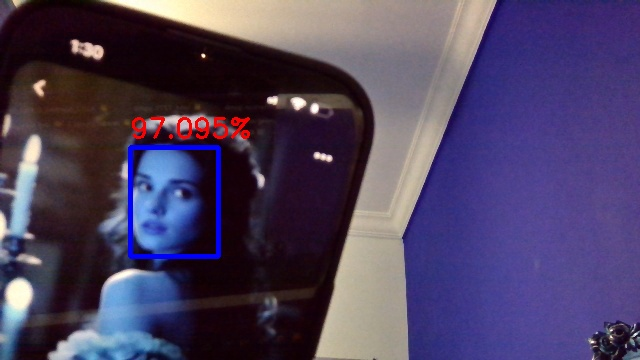

In [19]:
detect_faces(net, img_np)
display(Image("photo2.jpg"))